In [40]:
# This code was basically written by Philipp S. Arndt 

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import json
import requests
import os
#!pip3 install ipympl
import ipympl

%matplotlib notebook

In [41]:
class dataCollector:
    def __init__(self, beam=None, oaurl=None, track=None, date=None, latlims=None, lonlims=None):
        if (beam is None) or ((oaurl is None) and (None in [track, date, latlims, lonlims])):
            raise Exception('''Please specify a beam and 
            - either: an OpenAltimetry API url, 
            - or: a track, date, latitude limits and longitude limits.''')
        else:
            if oaurl is not None:
                url = oaurl
                tofind = '&beamName='
                ids = url.find(tofind)
                while ids>-1:
                    url = url.replace(url[ids:ids+len(tofind)+4],'')
                    ids = url.find(tofind)
                iprod = url.find('/atl')
                url = url.replace(url[iprod:iprod+6],'/atlXX')
                url += tofind + beam + '&client=jupyter'

                idate = url.find('date=') + len('date=')
                date = url[idate:idate+10]
                itrack = url.find('trackId=') + len('trackId=')
                trackend = url[itrack:].find('&')
                track = int(url[itrack:itrack+trackend])
                bb = []
                for s in ['minx=', 'maxx=', 'miny=', 'maxy=']:
                    ids = url.find(s) + len(s)
                    ide = url[ids:].find('&')
                    bb.append(float(url[ids:ids+ide]))
                lonlims = bb[:2]
                latlims = bb[2:]
            elif None not in [track, date, latlims, lonlims]:
                url = 'https://openaltimetry.org/data/api/icesat2/atlXX?'
                url += 'date={date}&minx={minx}&miny={miny}&maxx={maxx}&maxy={maxy}&trackId={track}&beamName={beam}'.format(
                        date=date,minx=lonlims[0],miny=latlims[0],maxx=lonlims[1],maxy=latlims[1],track=track,beam=beam)
                url += '&outputFormat=json&client=jupyter'
            
            self.url = url
            self.date = date
            self.track = track
            self.beam = beam
            self.latlims = latlims
            self.lonlims = lonlims
            print('OpenAltimetry API URL:', self.url)
            print('Date:', self.date)
            print('Track:', self.track)
            print('Beam:', self.beam)
            print('Latitude limits:', self.latlims)
            print('Longitude limits:', self.lonlims)
            
    def requestData(self):
        import pandas as pd
        import json
        import requests
        
        print('---> requesting ATL03 data...',end='')
        product = 'atl03'
        request_url = self.url.replace('atlXX',product)
        data = requests.get(request_url).json()
        lat, lon, h, confs = [], [], [], []
        for beam in data:
            for confidence in beam['series']:
                for p in confidence['data']:
                    confs.append(confidence['name'])
                    lat.append(p[0])
                    lon.append(p[1])
                    h.append(p[2])
        self.atl03 = pd.DataFrame(list(zip(lat,lon,h,confs)), columns = ['lat','lon','h','conf'])
        print(' Done.')
        
        print('---> requesting ATL06 data...',end='')
        product = 'atl06'
        request_url = self.url.replace('atlXX',product)
        data = requests.get(request_url).json()
        self.atl06 = pd.DataFrame(data['series'][0]['lat_lon_elev'], columns = ['lat','lon','h'])
        print(' Done.')
        
        print('---> requesting ATL08 data...',end='')
        product = 'atl08'
        request_url = self.url.replace('atlXX',product)
        data = requests.get(request_url).json()
        self.atl08 = pd.DataFrame(data['series'][0]['lat_lon_elev_canopy'], columns = ['lat','lon','h','canopy'])
        print(' Done.')
        
def plotProductData(data,title='some ICESat-2 data',hlims='auto'):
    import numpy as np
    import matplotlib.pylab as plt
    import os
    if hlims == 'auto':
        lower = np.nanmin([np.nanmin(data.atl06.h),np.nanmin(data.atl08.h)])
        upper = np.nanmax([np.nanmax(data.atl06.h),np.nanmax(data.atl08.h)])
        hrange = upper - lower
        hlims = [lower - 0.2 * hrange, upper + 0.1 * hrange]
    fig = plt.figure(figsize=(9, 6), dpi= 80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    lat = np.nanmean(data.atl06.lat)
    lon = np.nanmean(data.atl06.lon)
    title += '\n'+data.date+', track'+str(data.track)+'-'+data.beam+' ({lat:.4f}N, {lon:.4f}E)'.format(lat=lat,lon=lon)
    ax.set_title(title)
    ax.set_xlabel('latitude')
    ax.set_ylabel('elevation [m]')
    
    
    
    #
    #
    # GEOID correction
    #
    #
    
    geoid = 17.276503
    
    atl03_plot = ax.scatter(data.atl03.lat,data.atl03.h-geoid,s=10,c='k',alpha=0.15,edgecolors='none',label='atl03')
    atl06_plot, = ax.plot(data.atl06.lat,data.atl06.h-geoid,c='r',ls='-',marker='o',ms=3,mfc='w',mec='r',label='atl06')
#     atl08_plot, = ax.plot(data.atl08.lat,data.atl08.h,c='b',ls='-',marker='D',ms=3,mfc='w',mec='b',label='atl08')
#     canopy_plot = ax.scatter(data.atl08.lat,data.atl08.h+data.atl08.canopy,s=30,c='b',alpha=0.5,edgecolors='none',label='canopy')
    ax.legend(handles=[atl03_plot,atl06_plot],loc='lower left')
#     ax.legend(handles=[atl03_plot,atl06_plot,atl08_plot,canopy_plot],loc='lower left')
    ax.set_xlim(data.latlims)
    ax.set_ylim(hlims)
#     if not os.path.exists('figs'):
#         os.makedirs('figs')
#     fn = ('figs/atl-03-06-08_' + data.date + '_track' + str(data.track) + '_beam' + data.beam + '_' 
#          + '{lat:.2f}N{lon:.2f}E'.format(lat=lat,lon=lon) + '.png')
#     plt.savefig(fn, dpi=150)

In [42]:
# Rift on Brunt:
# mydata = dataCollector(beam='gt2r',date='2019-04-20',track=344,latlims=[-75.475, -75.455],lonlims=[-26.5, -25.5])

# mydata = dataCollector(beam='gt2r',date='2019-03-06',track=1040,latlims=[82, 83],lonlims=[-80, -83.5])
# mydata = dataCollector(beam='gt3l',date='2019-06-05',track=1040,latlims=[82, 83],lonlims=[-80, -83.5])
# mydata = dataCollector(beam='gt2r',date='2019-09-04',track=1040,latlims=[82, 83],lonlims=[-80, -83.5])
# mydata = dataCollector(beam='gt2r',date='2019-12-03',track=1040,latlims=[82, 83],lonlims=[-80, -83.5])
# mydata = dataCollector(beam='gt3l',date='2019-12-04',track=1040,latlims=[81, 84],lonlims=[-80, -83.5])

# mydata = dataCollector(beam='gt2l',date='2020-01-01',track=95,latlims=[82.6, 82.9],lonlims=[-81.9, -81.1])
mydata = dataCollector(beam='gt2l',date='2019-01-03',track=95,latlims=[82.6, 82.9],lonlims=[-81.9, -81.1])


mydata.requestData()

OpenAltimetry API URL: https://openaltimetry.org/data/api/icesat2/atlXX?date=2019-01-03&minx=-81.9&miny=82.6&maxx=-81.1&maxy=82.9&trackId=95&beamName=gt2l&outputFormat=json&client=jupyter
Date: 2019-01-03
Track: 95
Beam: gt2l
Latitude limits: [82.6, 82.9]
Longitude limits: [-81.9, -81.1]
---> requesting ATL03 data... Done.
---> requesting ATL06 data... Done.
---> requesting ATL08 data... Done.


<IPython.core.display.Javascript object>


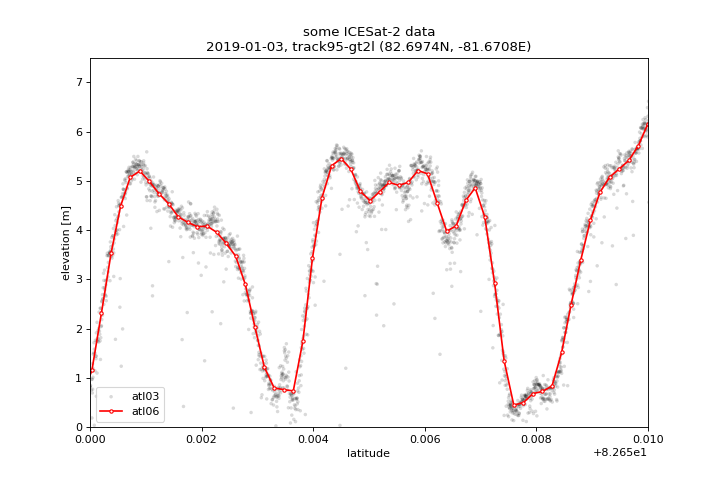

(82.65, 82.66)

In [47]:
%matplotlib notebook
# plotProductData(mydata,title='Rift in the Brunt Ice Shelf',hlims = [-10,40])
plotProductData(mydata,hlims = [0,7.5])
plt.xlim((82.65,82.66))